## <font color = "#CC3D3D">Case #1: GrabCut</font>

<hr>

### Step #1: Concept
<hr>

In [ ]:
- mask: 이전에 공부했던 마스크 연산시에 사용하는 마스크 영상(0또는 255의 이진 영상)과는 다르다. 0,1,2,3 로 구성되어 있다. 

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/nemo.jpg")

ROI = cv2.selectROI(source)
mask = np.zeros(source.shape[:2], np.uint8)

cv2.grabCut(source, mask, ROI, None, None, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype("uint8")
destination = source * mask2[:, :, np.newaxis]

mask *= 64

cv2.imshow("GrabCut", destination)
cv2.imshow("mask", mask)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


-1

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/pose1.jpg")

if source is None:
    print("Image load failed!")

mask = np.zeros(source.shape[:2], np.uint8)
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

ROI = cv2.selectROI(source)

cv2.grabCut(source, mask, ROI, background_model, foreground_model, 1, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype("uint8")
destination = source * mask2[:, :, np.newaxis]

cv2.imshow("GrabCut", destination)


def on_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(destination, (x, y), 3, (255, 0, 0), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
        cv2.imshow("GrabCut", destination)
    elif event == cv2.EVENT_RBUTTONDOWN:
        cv2.circle(destination, (x, y), 3, (0, 0, 255), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
        cv2.imshow("GrabCut", destination)
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(destination, (x, y), 3, (255, 0, 0), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
            cv2.imshow("GrabCut", destination)
        elif flags & cv2.EVENT_FLAG_RBUTTON:
            cv2.circle(destination, (x, y), 3, (0, 0, 255), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
            cv2.imshow("GrabCut", destination)


cv2.setMouseCallback("GrabCut", on_mouse)

while(1):
    key = cv2.waitKey()
    if key is 13:
        cv2.grabCut(source, mask, ROI, background_model, foreground_model, 1, cv2.GC_INIT_WITH_MASK)
        mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype("uint8")
        destination = source * mask2[:, :, np.newaxis]
        cv2.imshow("GrabCut", destination)
    elif key is 27:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


-1

## <font color = "#CC3D3D">Case #2: Moments based object detection</font>

In [1]:
import cv2
import matplotlib.pyplot as plt

obj = cv2.imread("images/spades.png", cv2.IMREAD_GRAYSCALE)
source = cv2.imread("images/symbols.png", cv2.IMREAD_GRAYSCALE)

if obj is None or source is None:
    print("Image load failed!")

    
_, object_binarization = cv2.threshold(obj, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
object_contour, _ = cv2.findContours(object_binarization, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
object_points = object_contour[0]


_, source_binarization = cv2.threshold(source, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
source_contours, _ = cv2.findContours(source_binarization, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


obj = cv2.cvtColor(obj, cv2.COLOR_GRAY2BGR)
destination = cv2.cvtColor(source, cv2.COLOR_GRAY2BGR)


for points in source_contours:
    rectangle = cv2.boundingRect(points)
    origin = (rectangle[0], rectangle[1] - 3)
    
    distance = cv2.matchShapes(object_points, points, cv2.CONTOURS_MATCH_I3, 0)
    
    cv2.putText(
        destination, str(round(distance, 4)), origin, cv2.FONT_HERSHEY_SIMPLEX,
        0.6, (255, 0, 0), 1, cv2.LINE_AA
        )

    if distance < 0.1:
        cv2.rectangle(destination, rectangle, (0, 0, 255), 2)
    else:
        cv2.rectangle(destination, rectangle, (255, 0, 0), 1)



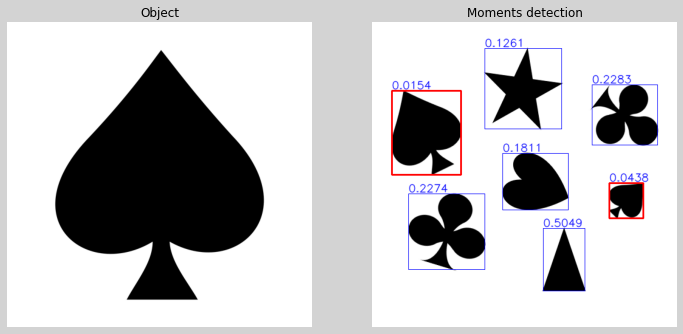

In [2]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Object").axis("off")
plt.imshow(obj[:, :, ::-1])

plt.subplot(122, title="Moments detection").axis("off")
plt.imshow(destination[:, :, ::-1])

plt.show()

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Object", obj)
cv2.imshow("Moments detection", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Case #3: Template matching</font>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/circuit2.bmp", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("images/crystal.bmp", cv2.IMREAD_GRAYSCALE)

if source is None or template is None:
    print("Image load failed!")


noise = np.zeros(source.shape, np.int32)
cv2.randn(noise, 50, 10)
source_noise = cv2.add(source, noise, dtype=cv2.CV_8UC3)


response = cv2.matchTemplate(source_noise, template, cv2.TM_CCOEFF_NORMED)
response_norm = cv2.normalize(response, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)


_, max_value, _, max_loc = cv2.minMaxLoc(response)
print("max value:", max_value)
print("max value location:", max_loc)

source = cv2.cvtColor(source, cv2.COLOR_GRAY2BGR)


temp_height, temp_width = template.shape
destination = cv2.cvtColor(source_noise, cv2.COLOR_GRAY2BGR)
destination = cv2.rectangle(destination, max_loc, (max_loc[0] + temp_width, max_loc[1] + temp_height), (0, 0, 255), 2)

max value: 0.9796592593193054
max value location: (568, 320)


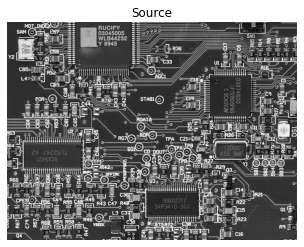

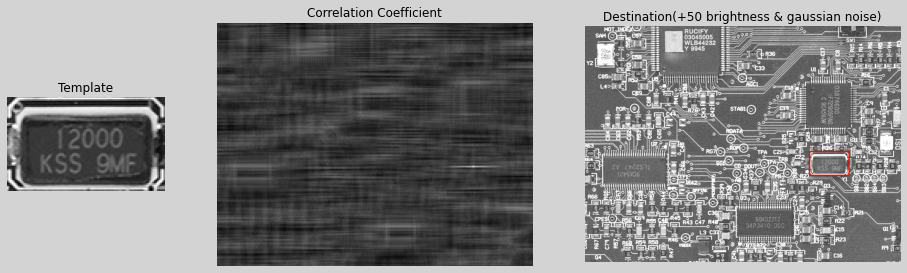

In [2]:
# pyplot으로 출력
plt.title("Source")
plt.axis("off")
plt.imshow(source[:, :, ::-1])
plt.show()

plt.figure(figsize=(16, 6), facecolor="lightgray")
gridspec = plt.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

plt.subplot(gridspec[0], title="Template").axis("off")
plt.imshow(template, "gray")

plt.subplot(gridspec[1], title="Correlation Coefficient").axis("off")
plt.imshow(response_norm, "gray")

plt.subplot(gridspec[2], title="Destination(+50 brightness & gaussian noise)").axis("off")
plt.imshow(destination[:, :, ::-1])

plt.show()

In [9]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Source", source)
cv2.imshow("Template", template)
cv2.imshow("Correlation Coefficient", response_norm)
cv2.imshow("Match Template", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/", cv2.IMREAD_GRAYSCALE)



## <font color = "#CC3D3D">Case #4: HOG(Histogram of Oriented Gradients)</font>

## <font color = "#CC3D3D">Training #1: Narrow snow app</font>